# Aims:
The purpose of this notebook is to built a proof of concept scorecard for predicting the application of a customer to the new CBILS loan and evaluate its power

<a id='ToC' > <a>
# Table of content:
* [Libraries](#lib)
* [Functions definition](#function)
* [Data preparation](#data)
* [Grouping the variables](#group)
* [building the scorecard](#scorecard)
* [Results](#result)

<a id='lib'> <a>
# ** Importing the libraries**


[Top](#Toc)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import cross_validate, KFold
from group import autogroup, autogroupcat
import warnings
warnings.filterwarnings('ignore')
import time


<a id='function'> <a>
# ** Defining useful functions **

 
[Top](#Toc) 

*Creating bootstrap to eliminate volatile variables *

In [17]:
def bootstrap(groupings, badflag, n_iteration):
    
    groupinglist=groupings.copy()
    mydf=pd.DataFrame()
    
    stopcondition=1
    while stopcondition>0:
        listofvar=[]
        grplist=[]
        woelist=[]
        for group in groupinglist:
            group.transform(mydf, group=True)
            listofvar += [group.var_name]
            grplist += [listofvar[-1]+'_grp']
            woelist += [grplist[-1]+'_WoE']

        bootset=mydf[grplist]
        bootset['bad']=badflag
        samplelist=[]
        for n in range(n_iteration):
            samplelist+=['s'+str(n)]
        for sl in samplelist:
            blop=np.random.uniform(size=len(bootset))
            bootset[sl]=blop.round()

        keeper=np.array([0]*len(listofvar))
        Gini=[]
        for sl in samplelist:
            print('Sample {} over {}'.format(sl[1:], n_iteration))
            train_set=bootset[bootset[sl]==1]
            train_set=train_set.sample(frac=1, replace=True)
            test_set=bootset[bootset[sl]==0]
            test_set=test_set.sample(frac=1, replace=True)
            for grp, grps in zip( grplist,groupinglist):
                #print(grp)
                gp=autogroupcat(train_set,grp,'bad',def_value=grps.valist()) 
                gp.transform(train_set)
                gp.apply(test_set[grp], test_set)

            clf=LogisticRegression()
            clf.fit(train_set[woelist], train_set['bad'])
            gini=round((roc_auc_score(test_set['bad'], clf.predict_proba(test_set[woelist])[:,1])-0.5)*2*100,2)
            print ('gini on validation =',gini)
            print ('gini on developement =',
                   round((roc_auc_score(train_set['bad'],
                                        clf.predict_proba(train_set[woelist])[:,1])-0.5)*2*100,2))
            Gini+=[gini]
            coef=-clf.coef_[0]
            intercept=-clf.intercept_[0]
            print('list of the coefficients:',coef)
            keeplist=np.array([0 if x>0 else 1 for x in coef])
            keeper+= keeplist
        #print(keeper) 
        print('Average gini over these {} bootstrap samples: {}'.format(n_iteration, np.average(Gini)))
        if keeper.max()>round(n_iteration/10):
            _=groupinglist.pop(keeper.argmax())
            print('variable {} has been removed as it changed its sign {} times over {}'.format(listofvar[keeper.argmax()],
                                                                                              keeper.max(),
                                                                                              n_iteration))
            print('*'*10, 'NEXT ITERATION', '*'*10)
        else:
            stopcondition=0
            print('No variable has changed its sign more than {} times over {}.'.format(round(n_iteration/10), 
                                                                                        n_iteration))
    return groupinglist

*Creating a scaled scorecard*

In [4]:
def scoring(GL, badflag, ES=160, PDO=20, save=False):
    mydf=pd.DataFrame()
    mydf['bad']=badflag
    scorevar=[]
    woelist=[]
    grplist=[]
    for group in GL:
        group.transform(mydf, group=True)
        scorevar+=[group.var_name]
        woelist+=[group.var_name+'_WoE']
        grplist+=[group.var_name+'_grp']
    LR=LogisticRegression()
    LR.fit(mydf[woelist], badflag)
    coef=-LR.coef_[0]
    intercept=-LR.intercept_[0]

    alpha=np.log(2)/PDO
    beta=-ES*alpha

    mydf['score']=0

    for elem,woe,coe in zip(scorevar, woelist, coef):
        mydf[elem]=((mydf[woe]*coe)+((intercept-beta)/len(scorevar)))/alpha
        mydf['score']+=mydf[elem]


    list_of_pts=[]
    for pts, grp in zip(scorevar,grplist):
        df1=mydf[[grp, pts]].drop_duplicates().sort_values([pts])
        df1[pts]=round(df1[pts])
        df1.reset_index(drop=True, inplace=True)
        if save==True:
            df1.to_csv(pts+'.csv', index=False)
        list_of_pts+=[df1]
    if save==True:
        for group in GL:
            bla=pd.read_csv(group.var_name+'.csv', header=None)
            try: 
                blop=blop.append(bla)
            except:
                blop=bla.copy()
        blop.columns=['group', 'points']
        blop.reset_index(drop=True, inplace=True)
        blop.to_csv('scorecard.csv', index=False)
    for elem in list_of_pts:
        print(elem, end='\n\n')
    return LR, mydf, list_of_pts


In [5]:
def aggregate_score(score, target):
 
    bla=pd.crosstab(score, target)
    good=np.array(bla[0])
    goods=100*good.cumsum()/sum(good)
    bad=np.array(bla[1])
    bads=100*bad.cumsum()/sum(bad)
    xs=bla.index.tolist()

    return xs, goods, bads



def plot_bad_and_good (xs, goods, bads):
    fig=plt.figure()
    plt.plot(xs, bads, c='r', label='Cumulative Bad' )
    plt.plot(xs, goods, '--', c='k', label='Cumulative Good')

    plt.xlabel('Score \n(Evenscore=160 and PDO=20)')
    plt.ylabel ('Cumulative Bad (red)\nCumulative Good (black)')
    plt.ylim([0,105])
    plt.legend()
    plt.show()
    return fig

def plot_compare_roc(list_of_goods, list_of_bads, list_of_model):
    fig=plt.figure(figsize=(8,7))
    for goods, bads, model in zip(list_of_goods, list_of_bads, list_of_model):
        plt.plot(goods, bads,  label=model)

    plt.xlabel('Cumulative goods')
    plt.ylabel('Cumulative bads')
    plt.legend()
    plt.show()
    return fig

def characterize(list_of_score, target, list_of_model):
    list_of_goods, list_of_bads=[],[]
    for score in list_of_score:
        scored=aggregate_score(score, target)
        list_of_goods += [scored[1]]
        list_of_bads += [scored[2]]
        plot_bad_and_good(scored)
    
    plot_compare_roc(list_of_goods, list_of_bads, list_of_model)   

<a id='data'> <a>
# **Data preparation**

 
[Top](#Toc)  

*Read in data*

In [6]:
df=pd.read_csv('mydata.csv')

In [7]:
df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,cbil_flag,segment
0,0.0,0.000000,0.0,0.000000,0.0,1015.52,13880.531230,0.0,0.0000,-1.000000e+10,...,-43114.62,-9.0,-9.0,10.0,NaN,0.91,NaN,0,0,BB RM
1,0.0,0.000000,0.0,0.000000,0.0,25000.00,327829.660100,0.0,0.0000,-1.000000e+10,...,4731.78,16.0,100.0,NaN,4.2,0.79,NaN,0,0,Commercial
2,0.0,0.000000,999.0,10.285714,0.0,1818236.42,80.619137,28.0,-703724.0038,1.538460e+01,...,-4552032.90,17.0,100.0,NaN,5.1,0.23,NaN,0,0,Commercial
3,0.0,0.666667,999.0,0.000000,0.0,13258.61,698.818667,0.0,0.0000,0.000000e+00,...,-845925.41,NaN,NaN,NaN,NaN,-99999.00,NaN,0,0,Commercial
4,0.0,0.000000,0.0,0.000000,0.0,1371610.78,4.321175,0.0,0.0000,-1.000000e+10,...,0.00,-9.0,-9.0,NaN,NaN,0.46,NaN,0,0,Commercial


*Identifying the initial variables*

In [8]:
best20=df.columns.tolist()[:-2]
best20

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48']

In [9]:
dfa=df.copy()
dfa=dfa[best20+['cbil_flag' ]]
dfa.fillna(-9876543, inplace=True)
dfa.reset_index(inplace=True)
dfa=dfa.drop(['index'], axis=1)
dfa.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,cbil_flag
0,0.0,0.000000,0.0,0.000000,0.0,1015.52,13880.531230,0.0,0.0000,-1.000000e+10,...,50000.0,-43114.62,-9.0,-9.0,10.0,-9876543.0,0.91,-9876543,0,0
1,0.0,0.000000,0.0,0.000000,0.0,25000.00,327829.660100,0.0,0.0000,-1.000000e+10,...,0.0,4731.78,16.0,100.0,-9876543.0,4.2,0.79,-9876543,0,0
2,0.0,0.000000,999.0,10.285714,0.0,1818236.42,80.619137,28.0,-703724.0038,1.538460e+01,...,0.0,-4552032.90,17.0,100.0,-9876543.0,5.1,0.23,-9876543,0,0
3,0.0,0.666667,999.0,0.000000,0.0,13258.61,698.818667,0.0,0.0000,0.000000e+00,...,806212.0,-845925.41,-9876543.0,-9876543.0,-9876543.0,-9876543.0,-99999.00,-9876543,0,0
4,0.0,0.000000,0.0,0.000000,0.0,1371610.78,4.321175,0.0,0.0000,-1.000000e+10,...,0.0,0.00,-9.0,-9.0,-9876543.0,-9876543.0,0.46,-9876543,0,0


*Using autogrouping to create a first draft of scorecard*

In [10]:
varlist=best20[:-2]
midict={}
for var in varlist:
    
    for i in [2,1,0,-1,-2,-3]:
        l=len(round(dfa[var],i).unique())
        n=i
        if l<5000:
            break
    midict[var]=n

In [11]:
dd=pd.DataFrame()
groupinglist=[]
for var in best20[:-2]:
    G=autogroup(dfa, var, 'cbil_flag', rounding=midict[var])#, def_value=[-9876543.0])
    G.transform(dd)
    print(var)
    print(G)
    print('*'*20)
    groupinglist+=[G]

var_0
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->0.0:                         137092    6380    86.8 %        0.04    0.02
1.0-->6.0:                                 11228     664     7.2 %        0.06   -0.22
7.0-->182.0:                                9530     447     6.0 %        0.04    0.01
Information value: 0.0
Gini: 1.79

********************
var_1
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->0.0:                         139549    6288    88.2 %        0.04    0.05
0.01-->2.0:                                 6906     258     4.3 %        0.04    0.24
2.04-->7.0:                                 5654     321     3.6 %        0.05   -0.18
7.2-->86.0:                                 5024     490     3.3 %        0.09   -0.72
86.14-->5627.5:                              717     134     0.5 %        0.16   -1.37
Information value: 0.05
Gini: 6.19

********************
var_2

var_15
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-38942.3:                     45435     726    27.9 %        0.02    1.09
-25292.8-->8.8:                             5386     194     3.4 %        0.03    0.28
8.9-->23.0:                                15578    1106    10.1 %        0.07    -0.4
23.1-->42.4:                               25632    2287    16.9 %        0.08   -0.63
42.5-->78.1:                               31167    2121    20.1 %        0.06   -0.36
78.2-->88.2:                                5249     314     3.4 %        0.06   -0.23
88.3-->97.5:                                5283     240     3.3 %        0.04    0.04
97.6-->42600.0:                            24120     503    14.9 %        0.02    0.82
Information value: 0.42
Gini: 33.23

********************
var_16
Value                                       Good     Bad       Vol    Bad Rate     WoE
-12374400.0-->-9876543.0:                  45435     726  

var_26
Value                                       Good     Bad       Vol    Bad Rate     WoE
-10000000000.0-->-0.01:                    11698     671     7.5 %        0.05   -0.19
0.0-->0.01:                               140525    6432    88.9 %        0.04    0.04
0.02-->10000000000.0:                       5627     388     3.6 %        0.06   -0.37
Information value: 0.01
Gini: 3.23

********************
var_27
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-0.89:                         5084     429     3.3 %        0.08   -0.58
-0.88-->0.0:                                6721     458     4.3 %        0.06   -0.36
0.01-->0.26:                               11383     465     7.2 %        0.04    0.15
0.27-->0.95:                               61781    3006    39.2 %        0.05   -0.02
0.96-->1.64:                               57133    2276    35.9 %        0.04    0.18
1.65-->2.8:                                10627     525   

var_40
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9877000.0-->10000.0:                      85165    2553    53.1 %        0.03    0.46
11000.0-->19000.0:                          5542     206     3.5 %        0.04    0.24
20000.0-->45000.0:                         20130    1379    13.0 %        0.06   -0.37
46000.0-->51000.0:                          5129     579     3.5 %         0.1   -0.87
52000.0-->70000.0:                          5502     231     3.5 %        0.04    0.12
71000.0-->92000.0:                          5366     278     3.4 %        0.05   -0.09
93000.0-->292000.0:                        21096    1377    13.6 %        0.06   -0.32
293000.0-->130000000.0:                     9920     888     6.5 %        0.08   -0.63
Information value: 0.2
Gini: 24.23

********************
var_41
Value                                       Good     Bad       Vol    Bad Rate     WoE
-596424000.0-->-292000.0:                  10224     845   

In [12]:
badlist=list(dfa.cbil_flag)
LR=LogisticRegression()
vlist=dd.columns.tolist()
stopcondition=-1
while stopcondition<0:
    dd=dd[vlist]
    LR.fit(dd,badlist)
    dfvar=pd.DataFrame({'variable':dd.columns.tolist(), 'weight':-LR.coef_[0]})
    dfvar.sort_values(['weight'], inplace=True)
    i=dfvar.index[0]
    stopcondition=dfvar.weight.tolist()[0]
    vlist.pop(i)

dfvar

,variable,weight
20,var_35_WoE,0.000133
3,var_3_WoE,0.018674
5,var_10_WoE,0.024467
2,var_2_WoE,0.026159
21,var_36_WoE,0.054535
7,var_15_WoE,0.055603
27,var_45_WoE,0.068597
26,var_44_WoE,0.078428
11,var_22_WoE,0.087084
0,var_0_WoE,0.093374


In [13]:
best20=dfvar.variable.tolist()
dd=pd.DataFrame()
groupinglist=[]
for var in best20:
    G=autogroup(dfa, var[:-4], 'cbil_flag', rounding=midict[var[:-4]])#, def_value=[-9876543.0])
    G.transform(dd)
    print(var)
    print(G)
    print('*'*20)
    groupinglist+=[G]

var_35_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-750791.0:                   109176    2909    67.8 %        0.03    0.58
-385084.0-->3.0:                           13763    1031     8.9 %        0.07   -0.46
4.0-->390.0:                               31855    3302    21.3 %        0.09   -0.78
391.0-->2833355.0:                          3056     249     2.0 %        0.08   -0.54
Information value: 0.39
Gini: 31.6

********************
var_3_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-10000000000.0-->0.0:                     149908    6953    94.9 %        0.04    0.02
0.01-->2800.0:                              7942     538     5.1 %        0.06   -0.36
Information value: 0.01
Gini: 2.15

********************
var_10_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-380181300.0-->-25300.0:                    4853     662     3.3 %     

var_32_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-5.16:                       133117    5443    83.8 %        0.04    0.15
-2.43-->-0.05:                              5368     475     3.5 %        0.08   -0.62
-0.04-->0.04:                               5214     350     3.4 %        0.06   -0.35
0.05-->0.44:                               10512     860     6.9 %        0.08   -0.54
0.45-->55.96:                               3639     363     2.4 %        0.09   -0.74
Information value: 0.09
Gini: 11.95

********************
var_21_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-6076155.0:                   45435     726    27.9 %        0.02    1.09
-897407.0-->0.0:                           39942    1048    24.8 %        0.03    0.59
1.0-->13.0:                                11449     554     7.3 %        0.05   -0.02
14.0-->27.0:                               11549  

var_42_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9876543.0-->-9.0:                        104068    2102    64.2 %        0.02    0.85
0.0-->1.0:                                  8623     294     5.4 %        0.03    0.33
2.0-->3.0:                                 12078     709     7.7 %        0.06   -0.21
4.0-->7.0:                                 15170    1427    10.0 %        0.09   -0.68
8.0-->10.0:                                 6021     798     4.1 %        0.12   -1.03
11.0-->15.0:                                5292     878     3.7 %        0.14   -1.25
16.0-->28.0:                                4620     936     3.4 %        0.17   -1.45
29.0-->99.0:                                1978     347     1.4 %        0.15   -1.31
Information value: 0.76
Gini: 45.0

********************
var_37_WoE
Value                                       Good     Bad       Vol    Bad Rate     WoE
-9877000.0-->-919000.0:                    89714   

<a id='scorecard'> <a>
# Building the scorecard
[Top](#Toc)

In [18]:
badflag=dfa.cbil_flag
GL = bootstrap(groupinglist, badflag, 10)

Sample 0 over 10
gini on validation = 61.39
gini on developement = 62.28
list of the coefficients: [-0.04344333 -0.2508101   0.07885803 -1.00599884 -0.02879271 -0.00881254
  0.01287913  0.09416521  0.09301759  1.11333776  0.1849559  -0.35461674
  0.09629626  0.15273729  0.23237634  0.34349389  0.18985774  0.23721178
  0.17789864  0.23343819 -0.00850768  0.35995261  0.88087591  0.40947315
  0.49063465  0.47528632  0.5573291   0.59722628  0.53423332]
Sample 1 over 10
gini on validation = 59.79
gini on developement = 62.61
list of the coefficients: [ 0.04834554  0.13731778  0.08788613 -0.30966365  0.08793708  0.17041326
  0.06150823  0.00851098  0.17083474  0.50683565  0.0227657  -0.76074332
  0.06552011  0.8274627   0.09687526  0.09225823  0.17540598  0.22440434
  0.14715237  0.25141543 -0.22226868  0.31693382  0.42660864  0.406688
  0.46600553  0.38547126  0.49202187  0.57511786  0.53794622]
Sample 2 over 10
gini on validation = 60.64
gini on developement = 62.45
list of the coefficient

gini on validation = 60.05
gini on developement = 62.25
list of the coefficients: [-0.02830688  0.055528   -0.00141532 -0.55237756  0.07445982 -0.03501821
  0.06324413  0.09574901  0.05598169  0.50923501  0.11029409  0.11731464
 -0.01661945  0.21332655  0.05163261  0.08193373  0.09303143  0.2116769
  0.35626128 -0.11993342  0.25772063  0.35751174  0.57311854  0.48777254
  0.47545152  0.54773999  0.58286693  0.56699875]
Sample 9 over 10
gini on validation = 59.71
gini on developement = 61.52
list of the coefficients: [ 0.06806099  0.16609138  0.17106413 -0.25478307  0.05685873  0.08014681
  0.03882156  0.0736395   0.18738086 -1.85471635  0.09028612  0.18544075
 -0.02704048  0.16223854  0.13532925  0.07158373  0.07624704  0.0865668
  0.18743186 -0.05641732  0.41143119  0.47686004  0.3164436   0.43808388
  0.46597081  0.54715193  0.43606112  0.54802251]
Average gini over these 10 bootstrap samples: 60.685
variable var_32 has been removed as it changed its sign 8 times over 10
********** N

gini on validation = 60.22
gini on developement = 61.18
list of the coefficients: [-0.0164725   0.34556576  0.0496537   0.05309194 -0.08800597  0.01764456
  0.04091324  0.1302999   0.15191191  0.1587385   0.10773778  0.21745455
  0.07375342  0.12748531  0.19515836  0.2070352   0.06814807  0.11543007
  0.42837325  0.44759251  0.4843531   0.47569511  0.50699191  0.56651509
  0.5805447   0.46625563]
Sample 8 over 10
gini on validation = 60.98
gini on developement = 60.91
list of the coefficients: [-0.00601232 -0.25537985  0.01330733  0.02508544  0.12485344  0.06522116
 -0.01083355  0.05362104  0.14614194  0.11777071  0.15827484  0.07195155
  0.13124114  0.15326739  0.22844511  0.17014812  0.26835656 -0.13683683
  0.3161516   0.50016117  0.50566389  0.50561072  0.50076207  0.50031777
  0.54352534  0.46967001]
Sample 9 over 10
gini on validation = 59.45
gini on developement = 61.33
list of the coefficients: [-0.08604     0.25376325  0.03230541  0.04754145 -0.06937535  0.07061859
  0.0433352

gini on validation = 60.38
gini on developement = 62.68
list of the coefficients: [-0.08233757  0.06153626  0.18079782 -0.04857814  0.12274596  0.08742802
  0.17258423  0.0290919  -0.07544578  0.03919727  0.20858451  0.08501345
  0.11542971  0.14824139  0.29294784  0.23079879  0.37103684  0.43720207
  0.37520016  0.42910748  0.44525822  0.56442356  0.5273413   0.48670343]
Sample 8 over 10
gini on validation = 61.33
gini on developement = 60.68
list of the coefficients: [ 0.14582205 -0.1264297   0.02082779 -0.05674146  0.03841605  0.05418165
  0.15269022  0.16187846  0.14342791  0.16437212  0.20074125  0.15721697
  0.12993081  0.20808453  0.18647839  0.3605256   0.24554288  0.5108795
  0.32631891  0.44231536  0.51492005  0.53115054  0.5614245   0.48710031]
Sample 9 over 10
gini on validation = 61.22
gini on developement = 62.29
list of the coefficients: [ 0.13220737  0.00637462  0.03701004  0.07400542  0.02276024  0.13377191
  0.09587484 -0.05854014  0.12528937  0.08101346  0.18714801  

gini on validation = 61.54
gini on developement = 62.04
list of the coefficients: [0.18239809 0.03446061 0.05579471 0.01148888 0.13643349 0.16331528
 0.12881936 0.11543282 0.1797944  0.03363543 0.1277195  0.28070462
 0.22542798 0.21057161 0.3247666  0.56226722 0.31951838 0.43848703
 0.46181824 0.52680859 0.57602339 0.51023014]
Sample 9 over 10
gini on validation = 61.29
gini on developement = 61.7
list of the coefficients: [-0.06879228 -0.00782534  0.05936955  0.10718005  0.18904996  0.36473697
  0.12510267  0.14889866  0.11120988  0.02013927  0.01111032  0.30450383
  0.21865008  0.20742066  0.44785141  0.32571815  0.41593883  0.45336347
  0.48696282  0.46747659  0.57040407  0.56632403]
Average gini over these 10 bootstrap samples: 60.565
variable var_3 has been removed as it changed its sign 6 times over 10
********** NEXT ITERATION **********
Sample 0 over 10
gini on validation = 59.77
gini on developement = 63.57
list of the coefficients: [0.06340548 0.03210551 0.09527913 0.16802692

gini on validation = 59.38
gini on developement = 62.0
list of the coefficients: [0.06905277 0.06956743 0.10027531 0.10096436 0.13977344 0.12126568
 0.14652302 0.13141214 0.15815683 0.23180301 0.11186297 0.41434604
 0.37528181 0.31514435 0.51083462 0.48075775 0.52872891 0.5357248
 0.53191011]
Sample 2 over 10
gini on validation = 60.86
gini on developement = 61.54
list of the coefficients: [ 0.00350731 -0.014969    0.17527912  0.15662644  0.20003893  0.16144869
  0.16594899  0.1250244   0.15731993  0.12410095  0.03747467  0.50249164
  0.39330121  0.41479396  0.48801783  0.44676298  0.55259157  0.53773718
  0.49028977]
Sample 3 over 10
gini on validation = 61.53
gini on developement = 60.71
list of the coefficients: [0.08859887 0.11164997 0.06259014 0.11306394 0.22597018 0.1753743
 0.06724003 0.0730079  0.2117321  0.11848319 0.18757381 0.36391749
 0.62193864 0.38722547 0.47510255 0.53687771 0.57532928 0.59817973
 0.54814232]
Sample 4 over 10
gini on validation = 61.04
gini on developeme

gini on validation = 61.45
gini on developement = 62.31
list of the coefficients: [0.21069086 0.17246395 0.18386286 0.17109816 0.07345832 0.07562115
 0.20610893 0.14718054 0.12056526 0.45294239 0.59283806 0.39233603
 0.45549998 0.52101948 0.54485821 0.50549862 0.51379677]
Sample 8 over 10
gini on validation = 60.85
gini on developement = 61.63
list of the coefficients: [ 0.13333109  0.09596039  0.13169162  0.14312615 -0.01988745  0.10532795
  0.26992006  0.23573961  0.2712495   0.34877175  0.58493561  0.42392054
  0.53527371  0.45529703  0.47805853  0.5456897   0.51776333]
Sample 9 over 10
gini on validation = 59.31
gini on developement = 63.24
list of the coefficients: [0.08532214 0.08501242 0.21265774 0.24956555 0.08633961 0.10084523
 0.31766343 0.11442536 0.22276897 0.38586662 0.21479772 0.48044907
 0.51947692 0.44852021 0.53322108 0.56369443 0.5247808 ]
Average gini over these 10 bootstrap samples: 60.071000000000005
No variable has changed its sign more than 1 times over 10.


<a id='result' > </a>

# Result 
[Top](#ToC)

point assigned to the different groups

In [19]:
LR, mydf, list_of_pts= scoring(GL, badflag, ES=160, PDO=20, save=False)


               var_22_grp  var_22
0   6010.0-->4798497360.0    13.0
1         -164680.0-->0.0    13.0
2           10.0-->6000.0    14.0
3  -9876540.0-->-205000.0    17.0

         var_46_grp  var_46
0       0.78-->0.96    10.0
1       0.62-->0.77    10.0
2       0.46-->0.61    11.0
3       0.97-->1.22    12.0
4       0.37-->0.45    13.0
5       0.28-->0.36    13.0
6  1.23-->1372219.0    14.0
7       0.17-->0.27    15.0
8   -99999.0-->0.16    18.0

                  var_16_grp  var_16
0                  1.6-->4.1    11.0
1                  0.1-->1.5    11.0
2                 4.2-->11.7    12.0
3                11.8-->16.2    13.0
4                -3.3-->-0.0    14.0
5                16.3-->26.9    14.0
6               -14.5-->-3.4    15.0
7                27.0-->40.8    16.0
8         -1249200.0-->-14.6    18.0
9                40.9-->54.0    18.0
10  -12374400.0-->-9876543.0    20.0
11               54.1-->76.0    22.0
12          76.1-->2243500.0    25.0

                var_21_grp  v

Separation power of the scorecard

Gini of the scorecard (on seen data): 0.609


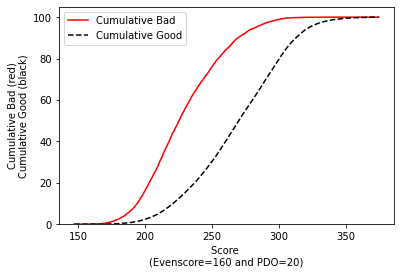

In [20]:
xs, goods, bads=aggregate_score(mydf.score, mydf.bad)
print('Gini of the scorecard (on seen data):',round(abs(roc_auc_score(mydf.bad, mydf.score)-0.5)*2,3))
_=plot_bad_and_good (xs, goods, bads)


In [21]:
df['score']=mydf.score
df_comm=df[df.segment=='Commercial']
df_RM=df[df.segment=='BB RM']

Gini of the scorecard (BBRM): 0.601


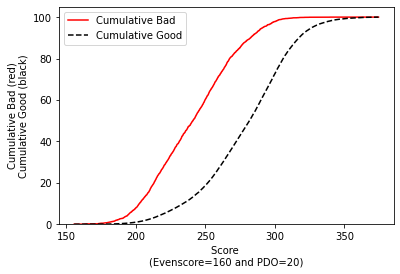

In [22]:
xs, goods, bads=aggregate_score(df_RM.score, df_RM.cbil_flag)
print('Gini of the scorecard (BBRM):',round(abs(roc_auc_score(df_RM.cbil_flag, df_RM.score)-0.5)*2,3))
_=plot_bad_and_good (xs, goods, bads)

Gini of the scorecard (Commercial): 0.546


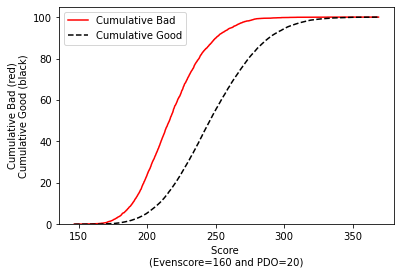

In [23]:
xs, goods, bads=aggregate_score(df_comm.score, df_comm.cbil_flag)
print('Gini of the scorecard (Commercial):',round(abs(roc_auc_score(df_comm.cbil_flag, df_comm.score)-0.5)*2,3))
_=plot_bad_and_good (xs, goods, bads)

In [ ]:
#!!jupyter nbconvert *.ipynb